# Import and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf

# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


import pandas
import h5py
import pickle

import datetime

2022-05-03 19:35:42.945002: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# configs
train, val, test = 0.6, 0.3, 0.1
Phi_sizes, F_sizes = (256, 256, 256), (256, 256, 256)
num_epoch = 500
batch_size = 1000
muon_feature_number = 6

# Load and Process Data

In [3]:
signal_1_df = "/global/home/users/yifengh3/VAE/new_data/h_signal_big.h5"
signal_2_df = "/global/home/users/yifengh3/VAE/new_data/hv_signal_big.h5"
signal_1_muon_df = "/global/home/users/yifengh3/VAE/new_data/muon_data/h_signal_big_muons.h5"
signal_2_muon_df = "/global/home/users/yifengh3/VAE/new_data/muon_data/hv_signal_big_muons.h5"
signal_1 = pandas.read_hdf(signal_1_df)
signal_2 = pandas.read_hdf(signal_2_df)
raw_signal_1_muon = pandas.read_hdf(signal_1_muon_df)
raw_signal_2_muon = pandas.read_hdf(signal_2_muon_df)

In [4]:
print("signal_1 data shape: {}".format(signal_1.shape))
print("signal_2 data shape: {}".format(signal_2.shape))
print("signal_1 muon data shape: {}".format(raw_signal_1_muon.shape))
print("signal_2 muon data shape: {}".format(raw_signal_2_muon.shape))

signal_1 data shape: (173692, 200)
signal_2 data shape: (157772, 200)
signal_1 muon data shape: (173692, 8)
signal_2 muon data shape: (157772, 8)


In [5]:
# no longer needed
# #Truncate the nan inside muon data
# signal_1_muon = raw_signal_1_muon.to_numpy()[:,:8]
# signal_2_muon = raw_signal_2_muon.to_numpy()[:,:8]
signal_1_muon, signal_2_muon = raw_signal_1_muon, raw_signal_2_muon

In [6]:
print("signal_1 muon data shape: {}".format(signal_1_muon.shape))
print("signal_2 muon data shape: {}".format(signal_2_muon.shape))

signal_1 muon data shape: (173692, 8)
signal_2 muon data shape: (157772, 8)


In [7]:
# mix two data array into one signal array
signal_1_combined = np.hstack((signal_1,signal_1_muon))
signal_2_combined =  np.hstack((signal_2,signal_2_muon))

In [8]:
# assign labels to signal and background data, 0 for sig1,  1 for sig2
# (updated since we might get multiple signals) 
labeled_sig1 = np.append(signal_1_combined,np.zeros((signal_1.shape[0],1)),axis=1)
labeled_sig2 = np.append(signal_2_combined,np.ones((signal_2.shape[0],1)),axis=1)

data = np.concatenate([labeled_sig1,labeled_sig2])

In [9]:
print(data.shape)

(331464, 209)


In [10]:
X = data[:,:-1]
y = data[:,-1]

In [11]:
print("shape of X: {}".format(X.shape))
print("shape of Y: {}".format(y.shape))

shape of X: (331464, 208)
shape of Y: (331464,)


In [12]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = labeled_sig1.shape[0] + labeled_sig2.shape[0]
weight_for_0 = (1 / labeled_sig1.shape[0]) * (total / 2.0)
weight_for_1 = (1 / labeled_sig2.shape[0]) * (total / 2.0)


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for background: {:.2f}'.format(weight_for_0))
print('Weight for signal: {:.2f}'.format(weight_for_1))

Weight for background: 0.95
Weight for signal: 1.05


In [13]:
# To categorical as stipulated in example
Y = to_categorical(y, num_classes=2)

# Reshape X to shape (number of jets, 50, 4)
X = X.reshape(-1,52,4)

# ignore the pid info
X = X[:,:,:3]

In [14]:
X = X.astype("float64")

In [15]:
print(X.shape)

(331464, 52, 3)


In [16]:
# # normalizing jets
# # copied from example
# import tqdm
# for x in tqdm.tqdm(X):
#     # now add the status bar :)
#     mask = x[:,0] > 0
#     yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
#     x[mask,1:3] -= yphi_avg
#     x[mask,0] /= x[:,0].sum()

In [17]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test, shuffle=True)

In [18]:
def to_combined_data(X):
    return [X[:,:50],X[:,-2:].reshape([-1,6])]

In [19]:
(X_train, X_val, X_test) = (to_combined_data(X_train),to_combined_data(X_val),to_combined_data(X_test))

In [20]:
print(X_train[0].shape,X_train[1].shape)

(198879, 50, 3) (198879, 6)


# Build and Train the Model

In [21]:
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, num_global_features = muon_feature_number)

Model summary:


2022-05-03 19:35:46.758647: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-03 19:35:46.759835: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-03 19:35:46.791406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:81:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-05-03 19:35:46.791428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-03 19:35:46.792972: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-03 19:35:46.793003: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-0

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 256)    1024        input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 256)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 256)    65792       activation[0][0]                 
______________________________________________________________________________________________

In [22]:
# now train the model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1**(1/5), patience=5, min_lr=1e-5,
                                                verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, 
                                              verbose=1)

callbacks = [reduce_lr,early_stop]

hist1 = pfn.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1)

Epoch 1/500


2022-05-03 19:35:47.804931: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-03 19:35:47.805407: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994530000 Hz


  1/199 [..............................] - ETA: 1:55 - loss: 143.2981 - acc: 0.4960

2022-05-03 19:35:48.220603: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


199/199 [==============================] - 3s 12ms/step - loss: 59.1950 - acc: 0.6144 - val_loss: 1.0078 - val_acc: 0.7723
Epoch 2/500
199/199 [==============================] - 2s 11ms/step - loss: 0.5405 - acc: 0.8411 - val_loss: 0.4362 - val_acc: 0.8795
Epoch 3/500
199/199 [==============================] - 2s 10ms/step - loss: 0.4403 - acc: 0.8755 - val_loss: 0.1915 - val_acc: 0.9279
Epoch 4/500
199/199 [==============================] - 2s 10ms/step - loss: 0.2031 - acc: 0.9250 - val_loss: 0.1880 - val_acc: 0.9311
Epoch 5/500
199/199 [==============================] - 2s 10ms/step - loss: 0.2028 - acc: 0.9250 - val_loss: 0.1792 - val_acc: 0.9326
Epoch 6/500
199/199 [==============================] - 2s 11ms/step - loss: 0.2103 - acc: 0.9220 - val_loss: 0.1672 - val_acc: 0.9363
Epoch 7/500
199/199 [==============================] - 2s 10ms/step - loss: 0.1843 - acc: 0.9305 - val_loss: 0.1656 - val_acc: 0.9347
Epoch 8/500
199/199 [==============================] - 2s 10ms/step - los

Epoch 62/500
199/199 [==============================] - 2s 10ms/step - loss: 0.0519 - acc: 0.9799 - val_loss: 0.0661 - val_acc: 0.9746
Epoch 63/500
199/199 [==============================] - 2s 10ms/step - loss: 0.0495 - acc: 0.9807 - val_loss: 0.0515 - val_acc: 0.9809
Epoch 64/500
199/199 [==============================] - 2s 10ms/step - loss: 0.0514 - acc: 0.9805 - val_loss: 0.0580 - val_acc: 0.9782
Epoch 65/500
199/199 [==============================] - 2s 10ms/step - loss: 0.0542 - acc: 0.9794 - val_loss: 0.0604 - val_acc: 0.9777
Epoch 66/500
199/199 [==============================] - 2s 10ms/step - loss: 0.0492 - acc: 0.9816 - val_loss: 0.0521 - val_acc: 0.9809
Epoch 67/500
199/199 [==============================] - 2s 10ms/step - loss: 0.0457 - acc: 0.9823 - val_loss: 0.0499 - val_acc: 0.9815
Epoch 68/500
199/199 [==============================] - 2s 10ms/step - loss: 0.0455 - acc: 0.9825 - val_loss: 0.0556 - val_acc: 0.9793
Epoch 69/500
199/199 [==============================] -

# Analyze the Model

In [23]:
# get predictions on test data
preds = pfn.predict(X_test, batch_size=10000)

# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.9982977224797005



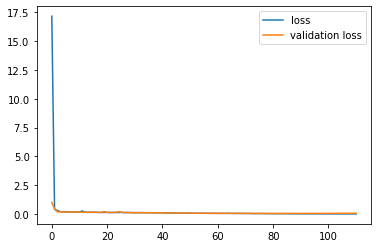

In [24]:
plt.plot(hist1.history["loss"],label="loss")
plt.plot(hist1.history["val_loss"],label="validation loss")
plt.legend()
plt.show()

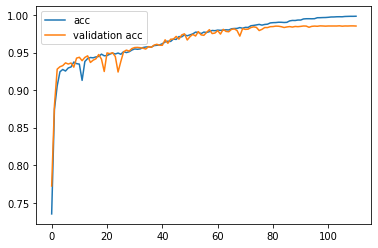

In [25]:
plt.plot(hist1.history["acc"],label="acc")
plt.plot(hist1.history["val_acc"],label="validation acc")
plt.legend()
plt.show()

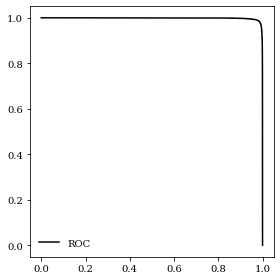

In [26]:
# get multiplicity and mass for comparison
preds = pfn.predict(X_test, batch_size=1000)
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='ROC')

plt.legend(loc='lower left', frameon=False)

plt.show()